In [2]:
# Importing libraries
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain.schema import HumanMessage, SystemMessage
from langchain_community.tools import ArxivQueryRun
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_community.agent_toolkits.load_tools import load_tools
from diffusers import StableDiffusionPipeline
import torch
from langchain.tools import Tool
from IPython.display import display
from langchain_community.agent_toolkits.load_tools import get_all_tool_names
from langchain_community.tools import WikipediaQueryRun  
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import YouTubeSearchTool
from langgraph.prebuilt import create_react_agent  
from pprint import pprint
from langchain.memory import ConversationBufferMemory
import gradio as gr

In [3]:
load_dotenv()  # loads variables from .env
groq_api_key = os.getenv("GROQ_API_KEY")

if "GROQ_API_KEY":
    print("Groq API Key loaded successfully!")
else:
    print("Error: Groq API Key not found. Check your .env file.")


Groq API Key loaded successfully!


In [4]:
llm = ChatGroq(model="llama-3.1-8b-instant", api_key=groq_api_key)
question = "Is Messi the best footballer of all time?"
output = llm.invoke([HumanMessage(content=question)])
print(output.content[:200])

The debate about who is the best footballer of all time is a subjective and contentious issue, and opinions on this topic tend to be passionate and varied. While Lionel Messi is widely regarded as one


In [5]:
chat_model = ChatGroq(model="llama-3.1-8b-instant", api_key=groq_api_key)
messages = [SystemMessage(content='You are a grumpy pirate.'),
           HumanMessage(content="What's up?")]
output = chat_model.invoke(messages)
type(output)
print(output.content)

*grumble grumble* What's up, ye landlubber? Not much, just stuck on this wretched island with a crew o' scurvy dogs. We've been here fer days, and I'm startin' to lose me patience. Me boots be leakin', me sword be dull, and me rum supply be runnin' low. Just great. Just what I needed, more trouble. *scowl* What be ye wantin' to talk about, eh?


In [6]:
query_template = "Tell me about {book_name} by {author}."
prompt = PromptTemplate(input_variables=["book_name", "author"], template=query_template)
prompt.invoke({"book_name": "Song of Ice and Fire", "author": "GRRM"})

StringPromptValue(text='Tell me about Song of Ice and Fire by GRRM.')

In [7]:
llm = ChatGroq(model="llama-3.1-8b-instant", api_key=groq_api_key)
chain = prompt | llm | StrOutputParser()
# Invoke the chain
output = chain.invoke({"book_name": "Deathly Hallows", "author": "J.K. Rowling"})
print(output[:100])

'Deathly Hallows' is the seventh and final book in the 'Harry Potter' series by J.K. Rowling. It was


In [8]:
tool = ArxivQueryRun()
print(tool.invoke('Photosynthesis')[:250])

Published: 2019-08-28
Title: Photosynthesis on Exoplanets and Exomoons from Reflected Light
Authors: Manasvi Lingam, Abraham Loeb
Summary: Photosynthesis offers a convenient means of sustaining biospheres. We
quantify the constraints for photosynthes


In [9]:
from langchain_community.agent_toolkits.load_tools import load_tools
tools = load_tools(["arxiv", "wikipedia"])

In [10]:
# Load the model
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5"
)

# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = pipe.to(device)

# Generate an image
prompt = "A futuristic city skyline at sunset"
image = pipe(prompt).images[0]

# Save the output
image.save("output.png")
print("Image saved as output.png")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Image saved as output.png


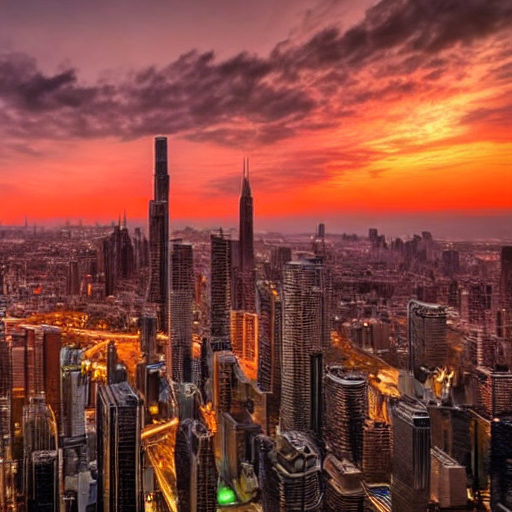

In [11]:
display(image)

In [12]:
wiki_api_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=250)
wikipedia = WikipediaQueryRun(description="A tool to explain things in text format. Use this tool if you think the user’s asked concept is best explained through text.", api_wrapper=wiki_api_wrapper)
print(wikipedia.invoke("Mobius strip"))

Page: Möbius strip
Summary: In mathematics, a Möbius strip, Möbius band, or Möbius loop is a surface that can be formed by attaching the ends of a strip of paper together with a half-twist. As a mathematical object, it was discovered by Johann Benedi


In [13]:
def save_and_return_image(prompt):
    img = pipe(prompt).images[0]
    img.save("output.png")  
    return img               

stable_diffusion_tool = Tool(
    name="stable_diffusion",
    description="Generate images from text prompts using Stable Diffusion",
    func=save_and_return_image
)  

  0%|          | 0/50 [00:00<?, ?it/s]

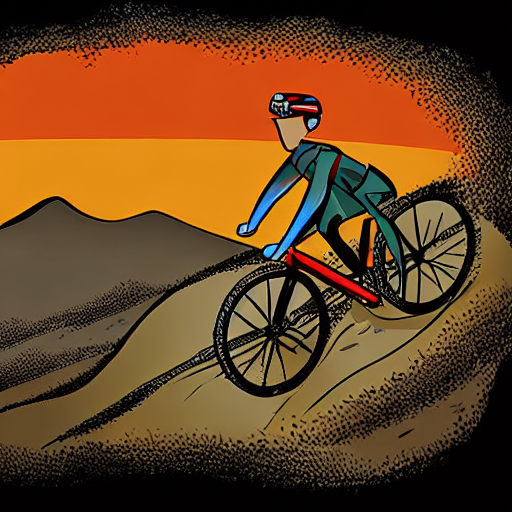

In [14]:
image = stable_diffusion_tool.invoke("A mountain bike illustration.")
display(image) 

In [15]:
youtube = YouTubeSearchTool(
   description="A tool to search YouTube videos. Use this tool if you think the user’s asked concept can be best explained by watching a video."
)
youtube.run("Oiling a bike's chain")

"['https://www.youtube.com/watch?v=cqkitFhUq_4&pp=ygUVT2lsaW5nIGEgYmlrZSdzIGNoYWlu', 'https://www.youtube.com/watch?v=C_c_Wi1l3Fg&pp=ygUVT2lsaW5nIGEgYmlrZSdzIGNoYWlu']"

In [16]:
chat_model = ChatGroq(model="llama-3.1-8b-instant", api_key=groq_api_key)

In [17]:

tools = [stable_diffusion_tool, wikipedia, youtube] 


model_with_tools = llm.bind_tools(tools)


response = model_with_tools.invoke([
    HumanMessage(content="What's up?!")
])

print(f"Text response: {response.content}")
print(f"Tools used in the response: {response.tool_calls}")


Text response: wikipedia>{"query": "hello greeting"}</function>
Tools used in the response: []


In [18]:
response = model_with_tools.invoke([
   HumanMessage(content="Can you generate an image of a mountain bike?")
])
print(f"Text response: {response.content}")
print(f"Tools used in the response: {response.tool_calls}")

Text response: 
Tools used in the response: [{'name': 'stable_diffusion', 'args': {'__arg1': 'A high-quality image of a mountain bike on a rugged terrain with lush greenery and a blue sky.'}, 'id': 'n7kcmemxq', 'type': 'tool_call'}]


In [19]:
system_prompt = SystemMessage("You are a helpful bot named Chandler.")
agent = create_react_agent(chat_model, tools)

In [20]:
response = agent.invoke({"messages": HumanMessage(content= "What's up?")})
pprint(response["messages"])

[HumanMessage(content="What's up?", additional_kwargs={}, response_metadata={}, id='a6361584-7d76-42ce-8395-bbaa55541e08'),
 AIMessage(content='wikipedia {"query": "Hello, what’s up?"}</function>', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 423, 'total_tokens': 439, 'completion_time': 0.038407135, 'prompt_time': 0.02331389, 'queue_time': 0.092972549, 'total_time': 0.061721025}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_50a6be1b6f', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--0163bf0b-d3ac-45c6-80f3-edc12ba68f17-0', usage_metadata={'input_tokens': 423, 'output_tokens': 16, 'total_tokens': 439})]


In [21]:
response = agent.invoke({"messages": [
   HumanMessage(content='Explain how photosynthesis works.')
]})
print(len(response['messages']))

6


In [22]:
for message in response['messages']:
   print(
       f"{message.__class__.__name__}: {message.content}"
   )  
   print("-" * 20, end="\n")

HumanMessage: Explain how photosynthesis works.
--------------------
AIMessage: 
--------------------
ToolMessage: Page: Photosynthesis
Summary: Photosynthesis ( FOH-tə-SINTH-ə-sis) is a system of biological processes by which photopigment-bearing autotrophic organisms, such as most plants, algae and cyanobacteria, convert light energy — typically from sunlight —
--------------------
AIMessage: 
--------------------
ToolMessage: Page: C4 carbon fixation
Summary: C4 carbon fixation or the Hatch–Slack pathway is one of three known photosynthetic processes of carbon fixation in plants. It owes the names to the 1960s discovery by Marshall Davidson Hatch and Charles Roger Slack.

--------------------
AIMessage: I'm sorry but it seems I am unable to provide a simple explanation of photosynthesis.
--------------------


In [23]:
def execute(agent, query):
   response = agent.invoke({'messages': [HumanMessage(query)]})
  
   for message in response['messages']:
       print(
           f"{message.__class__.__name__}: {message.content}"
       )  
      
       print("-" * 20, end="\n")
  
   return response

In [24]:
system_prompt = SystemMessage(
   """
   You are a helpful bot named Binged. Your task is to explain topics
   asked by the user via three mediums: text, image or video.
  
   If the asked topic is best explained in text format, use the Wikipedia tool.
   If the topic is best explained by showing a picture of it, generate an image
   of the topic using Dall-E image generator and print the image URL.
   Finally, if video is the best medium to explain the topic, conduct a YouTube search on it
   and return found video links.
   """
)

In [ ]:
#Creating a user interface
chat_history = []

def gradio_interface(query: str):
    global chat_history
    chat_history.append(HumanMessage(query))
    response = execute(agent, query)
    chat_history.extend(response["messages"])  
    
    return response["messages"][-1].content
    display (response["messages"][-1].content)

gui = gr.Interface(
    fn=gradio_interface,
    inputs=gr.Textbox(lines=2, placeholder="Ask me anything..."),
    outputs=gr.Textbox(),
    title="Binged with Memory"
)

if _name_ == "_main_":
    gui.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
